<a href="https://colab.research.google.com/github/srikanthsatyala/Leetcode-daily-challenge/blob/main/presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [225]:
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.losses import MSE
from sklearn.metrics import mean_squared_error as mse

import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [226]:
data = pd.read_csv('/content/sample_data/TSLA.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [227]:
data = data[['Date', 'Close']]
data.head()

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [228]:
scaler = StandardScaler()
close = np.array(data['Close'])
close = scaler.fit_transform(close.reshape(-1, 1))
close

array([[-1.36438413],
       [-1.36488785],
       [-1.38058745],
       ...,
       [ 3.81497063],
       [ 3.89691083],
       [ 4.98354095]])

In [229]:
#We are going to define our test and train dataset using create dataset which makes new x and y datasets
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [230]:
train_size = int(len(close) * 0.7) 
test_size = len(close) - train_size
train, test = close[0:train_size, :], close[train_size:len(close), :]
look_back = 10
trainX, trainY = create_dataset(train, look_back)  
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [231]:
#Simple LSTM
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(100, return_sequences=True, input_shape=(1, look_back)))
model.add(Dense(20))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1, validation_split=0.33 , batch_size=1, verbose=1)

1125/1125 [==============================] - 10s 6ms/step - loss: 0.0172 - val_loss: 0.0074


In [232]:
predicted = model.predict(testX)
print('MSE for predicted', mse(np.array(testY).reshape(-1),
                               np.array(predicted).reshape(-1)))

23/23 [==============================] - 1s 3ms/step
MSE for predicted 0.026053748720409834


In [233]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = np.reshape(trainPredict, (trainPredict.shape[0], trainPredict.shape[2]))
testPredict = np.reshape(testPredict, (testPredict.shape[0], testPredict.shape[2]))


23/23 [==============================] - 0s 2ms/step


In [234]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


In [235]:

trainPredictPlot = np.empty_like(close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot = trainPredictPlot.reshape(-1)
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict.reshape(-1)
# shift test predictions for plotting
testPredictPlot = np.empty_like(close)
testPredictPlot[:, :] = np.nan
testPredictPlot = testPredictPlot.reshape(-1)
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(close)-1] = testPredict.reshape(-1)

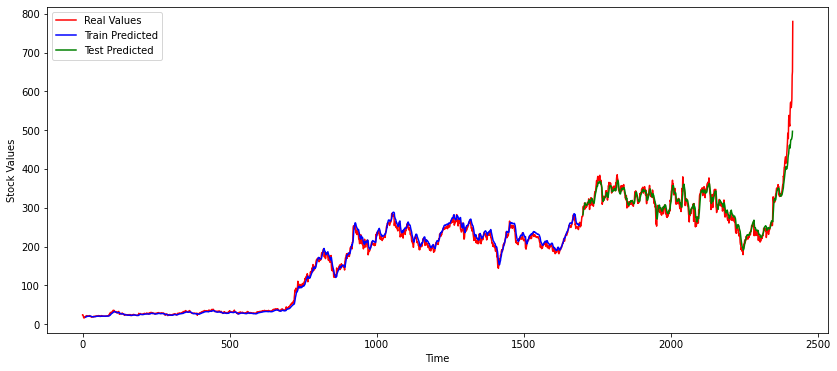

In [236]:
plt.figure(figsize=(14,6))
plt.plot(data['Close'],color="red",label="Real Values")
plt.plot(trainPredictPlot,color="blue",label="Train Predicted")
plt.plot(testPredictPlot,color="green",label="Test Predicted")
plt.xlabel("Time")
plt.ylabel("Stock Values")
plt.legend()
plt.show()